In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from scipy.stats import norm
from torch import nn

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Bandit

In [79]:
nb_arms = 5
#action = k between 0 and 4

class Bandit:
    def __init__(self, delta):
        self.delta = delta

    def step(self, x, y, action):
        reward = bandit_reward(self.delta, x, y, action)
        return reward

class BanditTask:
    def __init__(self, bandit):
        self.bandit = bandit
        
    def sample_data(self, size):
        rewards = []
        actions = []
        for i in range(size):
            x, y = circle_points()
            action = (np.random.choice(5))
            reward = self.bandit.step(x, y, action)
            rewards.append(reward)
            actions.append([x, y, action])
            #actions.append(action)
        return torch.Tensor(actions), torch.Tensor(rewards)

In [80]:
bandit = Bandit(0.5)
task = BanditTask(bandit)
task.sample_data(4)

In [ ]:
task=BanditTask(Bandit())
x_, y_ = task.sample_data(size=k)

# Contextual bandits

In [26]:
def bandit_reward(delta, x, y, k):
    r=x**2 + y**2
    if r>1:
        return -10**6
    if r<=delta:
        if k==1:
            return np.random.normal(1.2, 0.01**2, 1).item()
        elif k<=5:
            return np.random.normal(1.0, 0.01**2, 1).item()
    else:
        if k==1:
            return np.random.normal(1.2, 0.01**2, 1).item()
        
        elif x>0 and y>=0:
            if k==2:
                return np.random.normal(50, 0.01**2, 1).item()
            elif k<=K:
                return np.random.normal(1, 0.01**2, 1).item()
        elif x>=0 and y<0:
            if k==3:
                return np.random.normal(50, 0.01**2, 1).item()
            elif k<=K:
                return np.random.normal(1, 0.01**2, 1).item()
        elif x<0 and y<=0:
            if k==4:
                return np.random.normal(50, 0.01**2, 1).item()
            elif k<=K:
                return np.random.normal(1, 0.01**2, 1).item()
        else:
            if k==K:
                return np.random.normal(50, 0.01**2, 1).item()
            elif k<=5:
                return np.random.normal(1, 0.01**2, 1).item()


In [27]:
def circle_points():
    U1 = np.random.uniform(size = 1)
    U2 = np.random.uniform(size = 1)
    X = (np.sqrt(U2) * np.cos(2 * np.pi * U1)).item()
    Y = (np.sqrt(U2) * np.sin(2 * np.pi * U1)).item()
    #return X**2+Y**2
    return np.array([X, Y])

#plt.figure(figsize=(5,5))
for i in range(1000):
    a=circle_points()
    #plt.scatter(a.item(0), a.item(1))

In [7]:
bandit_reward(1, 0, 2)

49.999986677201704

In [8]:
class Uniform(object):

    def __init__(self, K, steps):
        self.K = K
        self.steps = 0
    
    def begin(self):
        pass

    def choose(self):
        return np.random.randint(1,self.K)
    
    def reward(self, r, k):
        pass

In [10]:
def random_exploration(n):
    R = []
    for i in range(n):
        a=circle_points()
        x,y = a.item(0), a.item(1)
        k = np.random.randint(1, 5)
        R.append(bandit_reward(x, y, k))
    return np.array(R)

In [11]:
random_exploration(10)

array([50.00000346,  1.00001491,  1.20015577,  1.1998359 ,  0.99994477,
        1.0000522 ,  1.0002368 ,  1.19996502,  1.0000056 ,  1.00006471])

In [ ]:
#Simulation
def simulation(algorithm, steps):
    choice, reward = np.zeros(steps), np.zeros(steps)
    
    for i in range(steps):
        # On peut utiliser i comme une variable dans les algorithmes
        a=circle_points()
        x,y = a.item(0), a.item(1)
        choice_i = algorithm.choose()

        reward_i = bandit_reward(x, y, choice_i)
        
        algorithm.reward(choice_i, reward_i)  #we update the reward given to the arm in the algorithm
        choice[i], reward[i] = choice_i, reward_i
    
    return reward

# MAML

In [68]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
            ]))

    def argforward(self,x,weights): 
        x=F.linear(x,weights[0],weights[1])
        x=F.relu(x)
        x=F.linear(x,weights[2],weights[3])           
        x=F.relu(x)
        x=F.linear(x,weights[4],weights[5])
        return x

In [72]:
class FMAML():
    def __init__(self,net,alpha,beta,H,num_metatasks, num_shots):
        self.net=net
        self.weights=list(net.parameters())
        self.alpha=alpha
        self.beta=beta
        self.H=H
        self.num_tasks_meta=num_metatasks #nombre de tâches que l'on utilise
        self.criterion=nn.MSELoss()  #criterion just to chose
        self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
        self.meta_losses=[]
        self.plot_every =10
        self.print_every = 10
        self.num_metatasks=num_metatasks
        self.num_shots = num_shots
        self.delta = 0.5

    def inner_loop(self,task, k):
        temp_weights=[w.clone() for w in self.weights]
        
        x, a = task.sample_data(size=self.H)
        x=torch.tensor(x).float().view(-1,1).to(device)
        a=torch.tensor(a).float().view(-1,1).to(device)
        
        output=self.net.argforward(x,a,temp_weights)
        loss=self.criterion(output,  )/self.H
        grads=torch.autograd.grad(loss,temp_weights)
        temp_weights=[w-self.alpha*g for w,g in zip(temp_weights,grads)] #temporary update of weights
        
        x_,y_=task.sample_data(size=self.k) #sampling D'
        x_=torch.tensor(x_).float().view(-1,1).to(device)
        y_=torch.tensor(y_).float().view(-1,1).to(device)
        output=self.net.argforward(x_,temp_weights)
        metaloss=self.criterion(output,y_)/self.k
        return metaloss, temp_weights
    
    def outer_loop(self,num_epochs):
        total_loss=0
        for epoch in range(1,num_epochs+1): #Correspond au "While not done"
            metaloss_sum=0
            for i in range(self.num_metatasks):
                
                task=BanditTask(Bandit(self.delta)) #.sample_data(size=self.k)
                metaloss, temp_weights=self.inner_loop(task, self.H)
                #metaloss, temp_weights=self.ML_point(task, self.k)
                metaloss_sum+=metaloss
            metagrads=torch.autograd.grad(metaloss_sum,self.weights)
            for w,g in zip(self.weights,metagrads):
                w.grad=g
            self.meta_optimiser.step()
            total_loss += metaloss_sum.item() / self.num_metatasks
            #if epoch % self.print_every == 0:
                #print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
            if epoch % self.plot_every == 0:
                self.meta_losses.append(total_loss / self.plot_every)
                total_loss = 0
                
    def plot_losses(self):
        plt.plot(self.meta_losses)
        plt.xlabel('Meta-Iteration')
        plt.ylabel('Meta-Loss')
        plt.title('Meta-Training Loss')
        plt.show()

In [83]:
bandit = Bandit(0.5)
task = BanditTask(bandit)
task.sample_data(4)

(tensor([[ 0.7091,  0.1026,  0.0000],
         [ 0.7473, -0.5114,  1.0000],
         [-0.4396, -0.0795,  3.0000],
         [ 0.2721, -0.9573,  1.0000]]),
 tensor([1.0000, 1.2000, 0.9999, 1.2001]))

# Parameters for training

In [73]:
# Définir les paramètres de l'algorithme MAML
alpha = 0.01
beta = 0.001
num_tasks = 20
k = 10
num_metatasks = 10
num_shots = 10

# Créer les tâches
#task = BanditTask(Bandit())
#task_test = BanditTask(Bandit())#.sample_data(3)

# Fixed variance

Excellent performances with a 0.01 variance.

MAML with variance 0.00001 behaves during the meta-training as the training only of MAML without meta-training and variance 0.01.

## 1000 meta-training epochs

In [74]:
# Créer une instance de la classe FMAML
maml = FMAML(FNet(), alpha, beta, k, num_metatasks, num_shots)

# Entraîner l'algorithme MAML
num_epochs = 10000
maml.outer_loop(num_epochs)

RuntimeError: The size of tensor a (30) must match the size of tensor b (10) at non-singleton dimension 0

In [ ]:
maml.plot_losses()

In [ ]:
bandit = Bandit()
task_test = BanditTask(bandit)

x,y = [], []
for i in range(nb_arms):
    x.append(i)
    y.append(bandit.step(i))
x, y = torch.Tensor(x).unsqueeze(1), torch.Tensor(y)

In [232]:
print("Real output: {} \n prediction: {} ".format(y, maml.output(x)))
maml.training(x,y)
print("prediction after one training step: {} ".format(maml.output(x)))

losses_1 = []
for i in range(100):
    losses_1.append(maml.training(x, y))

print("prediction after 100 training step: {} ".format(maml.output(x)))

losses_2 = []
for i in range(100):
    losses_2.append(maml.training(x, y))
    
print("prediction after 200 training step: {} ".format(maml.output(x)))

Real output: tensor([11.1171, -0.3937, 11.4129]) 
 prediction: tensor([[6.4834],
        [3.4910],
        [6.5842]], grad_fn=<AddmmBackward>) 
prediction after one training step: tensor([[6.5041],
        [3.5015],
        [6.5644]], grad_fn=<AddmmBackward>) 
prediction after 120 training step: tensor([[10.5630],
        [ 0.1628],
        [10.0102]], grad_fn=<AddmmBackward>) 
prediction after 150 training step: tensor([[10.8457],
        [-0.0382],
        [10.5133]], grad_fn=<AddmmBackward>) 


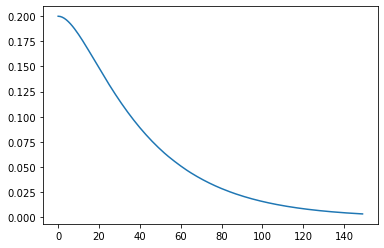

In [233]:
plt.plot(losses_1+losses_2)

## 1 Meta-training epoch

Funny curve with 0.01 variance for the rewards and 1000 training iterations.

In [103]:
# Créer une instance de la classe FMAML
maml = FMAML(FNet(), alpha, beta, k, num_metatasks, num_shots)

# Entraîner l'algorithme MAML
num_epochs = 0
#maml.outer_loop(num_epochs)

In [104]:
bandit = Bandit()
task_test = BanditTask(bandit)

x,y = [], []
for i in range(nb_arms):
    x.append(i)
    y.append(bandit.step(i))
x, y = torch.Tensor(x).unsqueeze(1), torch.Tensor(y)

In [105]:
print("Real output: {} \n prediction: {} ".format(y, maml.output(x)))
maml.training(x,y)
print("prediction after one training step: {} ".format(maml.output(x)))

losses_1 = []
for i in range(120):
    losses_1.append(maml.training(x, y))

print("prediction after 120 training step: {} ".format(maml.output(x)))

losses_2 = []
for i in range(30):
    losses_2.append(maml.training(x, y))
    
print("prediction after 150 training step: {} ".format(maml.output(x)))

Real output: tensor([ 0.9285,  8.4799, -1.9825]) 
 prediction: tensor([[0.2095],
        [0.2548],
        [0.2780]], grad_fn=<AddmmBackward>) 
prediction after one training step: tensor([[0.2381],
        [0.2986],
        [0.3297]], grad_fn=<AddmmBackward>) 
prediction after 120 training step: tensor([[3.0508],
        [3.5796],
        [0.5687]], grad_fn=<AddmmBackward>) 
prediction after 150 training step: tensor([[ 3.4957],
        [ 4.4096],
        [-0.1813]], grad_fn=<AddmmBackward>) 
